# **Polynomial Fitting**

In this tutorial, we will solve a 1-dimensional *regression* problem with a polynomial model.

We have a training set composed of inputs $\mathbf{x} =[x_{1},x_{2},..,x_{i}, ..., x_{N}]^T$ and labels $\mathbf{y} =[y_{1},y_{2},..,y_{i}, ..., y_{N}]^T$, where $x_{i}, y_{i} \in \mathbb{R}$.

The goal is to find a function $f(x): \mathbb{R} \to \mathbb{R}$ that fits well with my dataset.

In this case, we employ a parametrized linear model:

$f(x,\mathbf{w}) = w_0 + w_1 x + w_2x^2 + ... + w_M x^M = \sum_{j=0}^M w_j x^j$

where the learnable parameters are $\mathbf{w} = [w_0, w_1, .., w_M]^T$ and M is the order of the polynomial.

This model is linear because, even if it is not linear wrt the input x, it is linear wrt the parameters. It can be thus be written as:

$\hat{y}(x, \mathbf{w})= w^T \phi(x)$,

where $\phi(x) = [1, x, x^2, .., x^M]^T$

The linear models with a pre-computed transformation are called *linear basic function models*.

Let's use MSE as an objective:

$J = \frac{1}{2}\sum_{i=1}^N (y_i - \hat{y_i})^2$, where $\hat{y_i}$ is the prediction of our model for the input $x_i$.


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

First, let's define a function that computes the output value given the input and the weights:

In [ ]:
def polynomial_model(x, weights, order=2):
  """Computes the output Polynomial model parametrized by the weights.
  It also outputs the bases phi (usereful to compute the direct solution)
  """

  # Repeting the input x
  # (useful for vectorizing the operation => no for loops)
  x = np.expand_dims(x, axis=1)
  x = np.repeat(x, order+1, axis=1)

  # Computing the exponents
  exps = np.linspace(0, order, order+1)
  exps = np.expand_dims(exps, axis=1).T

  # Computing the bases
  bases = (x ** exps)

  # Computing the output
  output = (weights * bases).sum(1)

  return output, bases


# Example
weights = np.array([1,2,3])
x = np.array([1.0,0.1,0.01, 0.001])
out, bases = polynomial_model(x, weights, order=2)
print(out)
print(x.shape)
print(out.shape)
print(bases.shape)

[6.       1.23     1.0203   1.002003]
(4,)
(4,)
(4, 3)


# **1. Dataset creation**

Let's draw some samples for training and testing. In this case, the data are sampled from a sinusoidal function $y_{data} = sin(2\pi x)$. We also add some noise to account for uncertainty in the observations.

In [ ]:
def get_label(x, sigma=0.25, mu=0.0):
  """This function gets the label for the input x.
  It adds a small noise to model imperfect observations.
  """
  noise = sigma * np.random.randn(x.size)+ mu
  # In this case, we use a linear model
  return np.sin(2 * math.pi * x) + noise

In [ ]:
def get_dataset(N, sigma=0.25, mu=0.0):
  "This function creates a dataset with N examples."
  #x = np.random.uniform(low=0.0, high=1.0, size=N)
  x = np.linspace(0, 1, N)
  return x, get_label(x, sigma, mu)


In [ ]:
# Let's draw the training and test set
x_train, y_train = get_dataset(10)
x_test, y_test = get_dataset(100, sigma=0)

Note that we aren't adding noise to the test set. This operation is here done just to obtain an evaluation not biased by the additive noise. For now, we sampled only 10 training examples to mimic a challenging scenario with data scarcity.

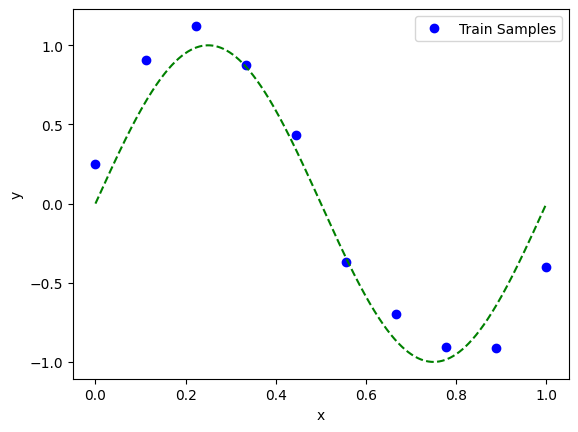

In [ ]:
# We can plot the training samples
plt.plot(x_train, y_train, 'o', color='blue')
plt.xlabel('x')
plt.ylabel('y')


# Let's plot the data geration function )
x_data = np.linspace(0, 1, 1000)
y_data = np.sin(2 * math.pi * x_data)
plt.plot(x_data , y_data, '--', color='green')
plt.legend(['Train Samples'])
plt.show()

**Remark**:

As you can see, we sample data from a sinusoidal function (with a little Gaussian noise added). In a real machine learning problem, however, we have **no access** to the **data generation** process. For example, in an object classification problem, we don't know the complex function that maps the pixels of an image to some output classes.

In this toy example, we assume to know the data generation function because, this way, we can easily **sample** examples from it.
In any case, the machine learning algorithm only sees the training samples drawn from this model and does not have access to the data generation function itself.

# **2. Training**
As we have seen in the lecture, also for linear basis function models the exact solution can be computed. In this case, the gradient is:

$\nabla J(\mathbf{w}) = (\mathbf{\Phi}^T\mathbf{\Phi}) \mathbf{w} - \mathbf{\Phi}^T\mathbf{y} $

If we set $\nabla J(\mathbf{w})=0$, the best weights $\mathbf{w}$ can be computes as:

$\mathbf{w} = (\mathbf{\Phi}^T\mathbf{\Phi})^{-1} \mathbf{\Phi}^T\mathbf{y} $

For a regression problem, we can use the Mean Squared Error (MSE) as the objective function (the lower the better):

In [ ]:
def mse(y, pred):
  """Mean Squared Error (MSE) averaged over all the N input samples"""
  return ((y - pred)**2).mean()

In [ ]:
def get_best_weight(x_train, y_train, order):
  """Compute the optimal solution with the given training set"""

  # Fake weight initialization (the weights are not used to compute the bases)
  weights = np.random.uniform(low=-1.0, high=1.0, size=order+1)
  y_hat, bases = polynomial_model(x_train, weights, order)

  # Computing the optimal solution
  phi_phiT = np.dot(bases.transpose(), bases)
  phi_phiT_inverse = np.linalg.inv(phi_phiT)
  phi_phiT_inverse_phiT  = np.dot(phi_phiT_inverse, bases.transpose())

  w_opt = np.dot(phi_phiT_inverse_phiT, y_train)

  return w_opt

def evaluate(x,y, w, order):
  """Returns the predictions on the given data samples wit the corresponding
  performance."""
  y_hat, _ = polynomial_model(x, w, order)
  return mse(y, y_hat), y_hat

def optimize_and_evaluate(x_train, y_train, x_test, y_test, order, plot=True):
  """Finds the optimal solution and evaluates its performance."""

  # Compute the optimal solution
  w_opt = get_best_weight(x_train, y_train, order)

  # Evaluate the performance
  train_loss, train_y_hat = evaluate(x_train, y_train, w_opt, order)
  test_loss, test_y_hat = evaluate(x_test, y_test, w_opt, order)

  # Getting the targeted output (over a lot of points)
  x_data = np.linspace(0, 1, 1000)
  y_data = np.sin(2 * math.pi * x_data)

  # Let's plot predictions vs labels
  if plot:
    plt.plot(x_data , y_data, '-', color='green')
    plt.plot(x_test, test_y_hat, '-', color='red')
    plt.plot(x_train, y_train, 'o', color='blue', fillstyle='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Target Function', 'Learned function', 'Training_data'])
    plt.show()

  return w_opt, train_loss, test_loss




Let's compute the best solution for different polynomial degrees:

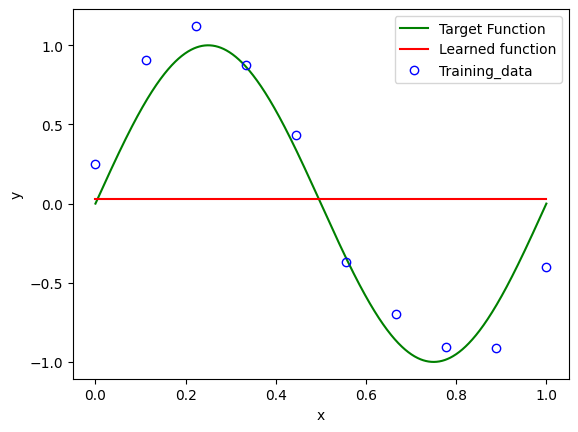

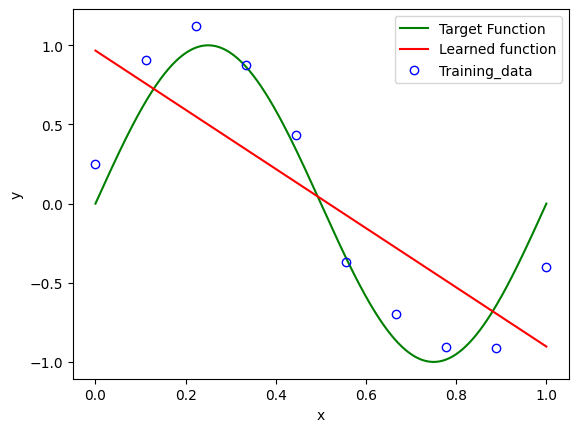

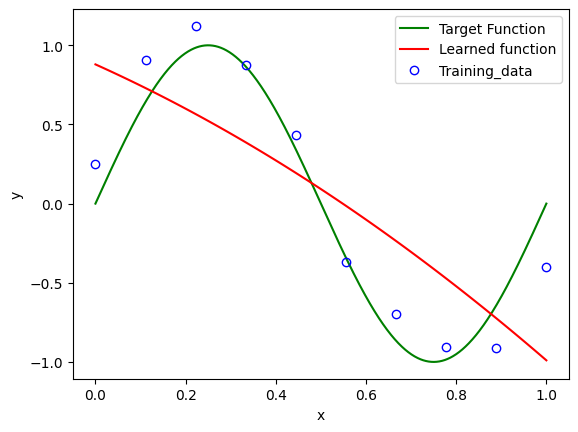

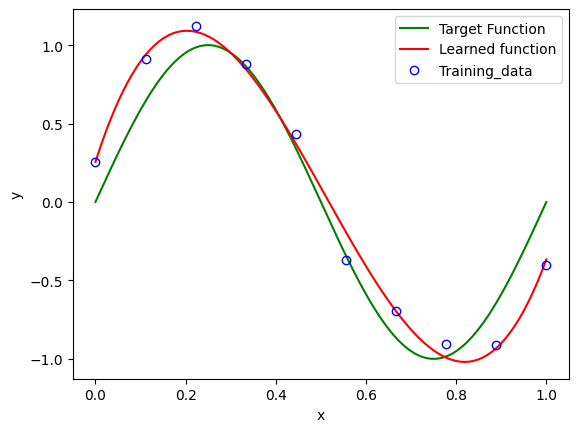

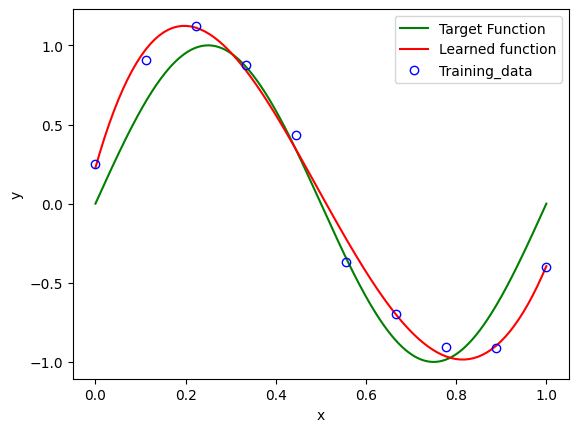

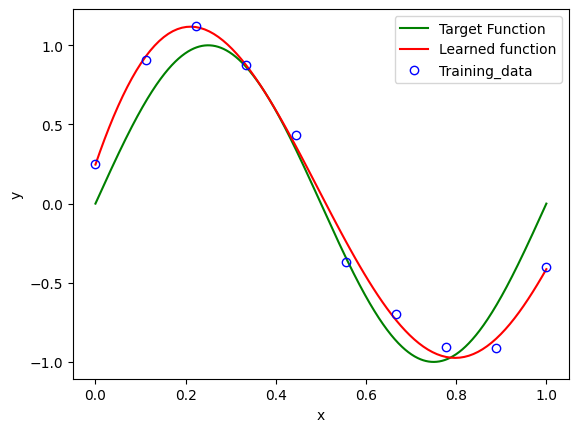

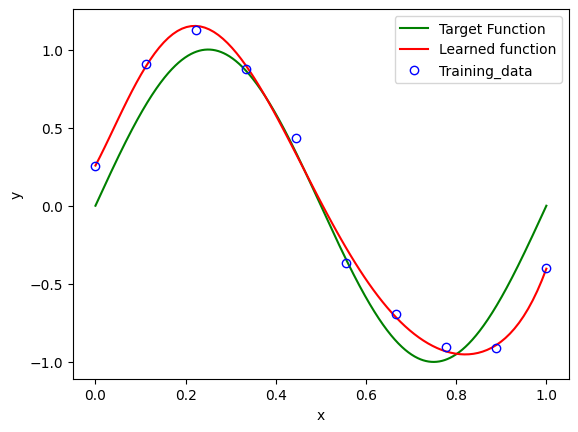

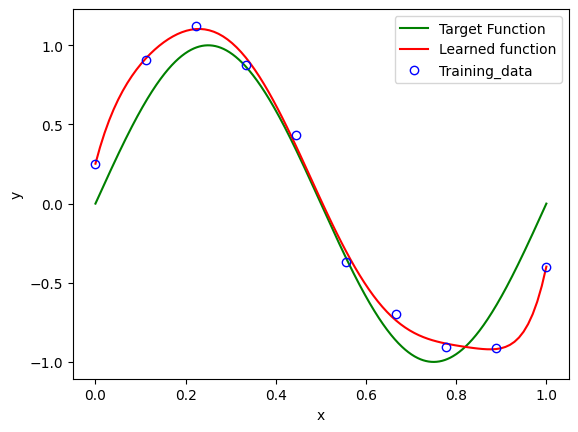

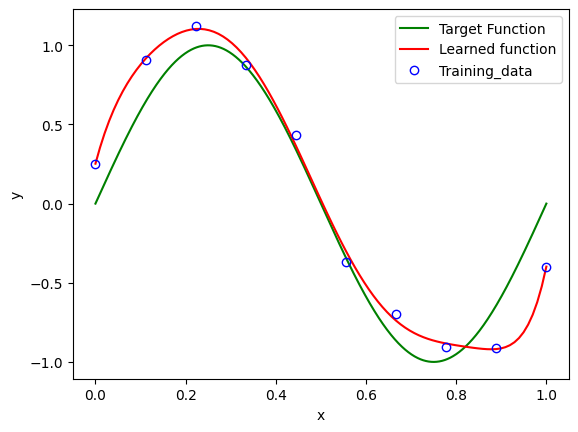

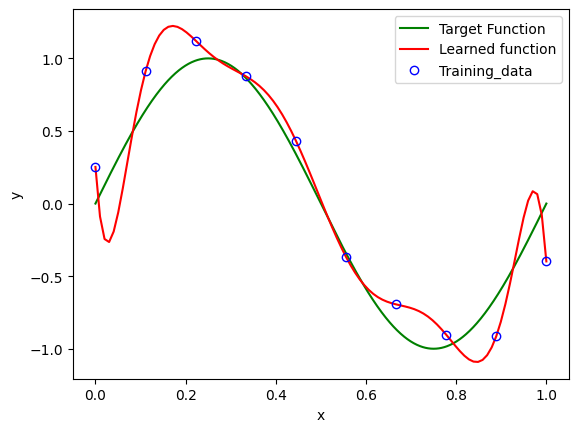

In [ ]:
w_opt_order = []
train_loss_order = []
test_loss_order = []

for order in range(0, 10):
  w_opt, train_loss, test_loss = optimize_and_evaluate(x_train, y_train, x_test, y_test, order)

  # Appending the results for the various orders:
  w_opt_order.append(w_opt)
  train_loss_order.append(train_loss)
  test_loss_order.append(test_loss)


You can notice that the polynomial degree has a remarkable impact on the performance:
- If the degree is too low (i.e., $M< 2$), the model suffers from underfitting (the function that the model can implement is too simple to model the input data).
- If the degree is too high ($M > 6$), the model overfits. The model fits perfectly the training data but fails to generalize on test data. This condition happens when the function implemented is too complex for the given problem. Intuitively, the model starts to tune itself on the noisy part of the observations.
- If the degree is $3 < M < 6$ we have a good fitting, as you can observe from the reasonable matching between the learned function and the one used to generate the data (targeted function).   

Side note: if model overfits, either increase the dataset or reduce the complexity.
bias vs variance - bias - underfitting(during training), variance - overfitting

Let's now plot the training and test performance for different polynomial degrees:

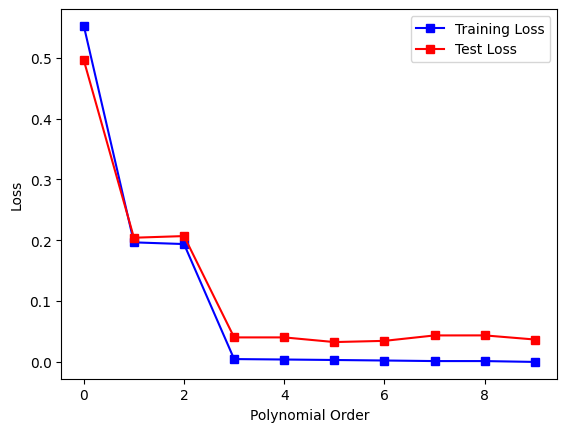

In [ ]:
plt.plot(train_loss_order, '-s', color='blue')
plt.plot(test_loss_order, '-s', color='red')
plt.xlabel('Polynomial Order')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Test Loss'])
plt.show()

The best performance is achieved when the order is between 3 and 5.
When the order is greater than 5, the training and test performances start diverging (which indicates overfitting).

# **Regularization by increasing data size**

The best way to counteract overfitting is to train our model with more data.
In the following, we train a polynomial model of order 9 with 10 or 100 training data points.

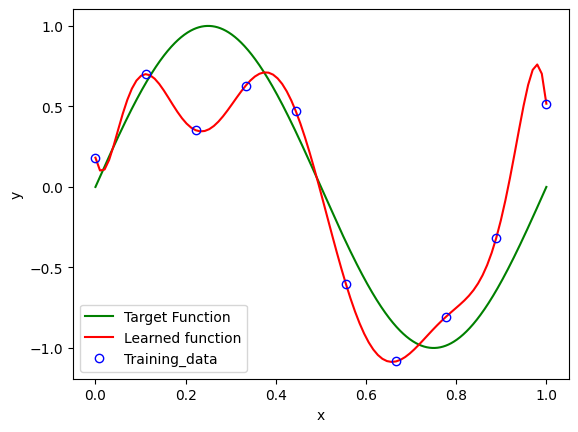

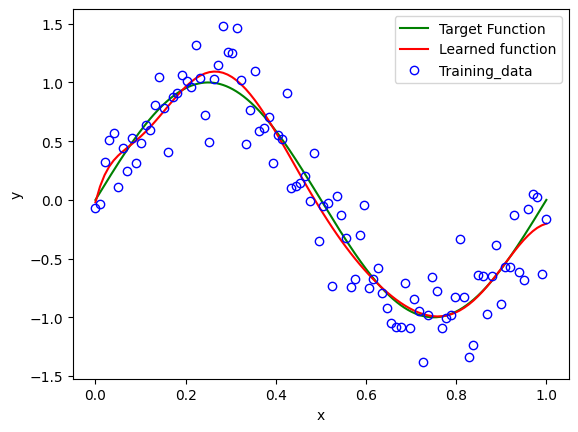

In [ ]:
w_opt_data = []
train_loss_data = []
test_loss_data = []

order = 9

x_train, y_train = get_dataset(10)
w_opt, train_loss, test_loss =  optimize_and_evaluate(x_train, y_train, x_test, y_test, order)

x_train, y_train = get_dataset(100)
w_opt, train_loss, test_loss =  optimize_and_evaluate(x_train, y_train, x_test, y_test, order)


for data_size in range(10, 105, 5):
  x_train, y_train = get_dataset(data_size)
  w_opt, train_loss, test_loss =  optimize_and_evaluate(x_train, y_train, x_test, y_test, order, plot=False)

  # Appending the results for the various orders:
  w_opt_data.append(w_opt)
  train_loss_data.append(train_loss)
  test_loss_data.append(test_loss)

The 9th-degree polynomial suffers from overfitting when training with 10 data points only. When we use 100 data points, we don't see overfitting anymore.

**Note**: Adding data is the best way to improve generalization. However, adding data is extremely expensive in a real machine learning problem. The data annotation part, in fact, typically needs human efforts, and creating a large dataset often has a huge cost.


Fortunately, there are other types of regularization. For instance, the L2 regularization (also known as weight decay). When applied to a linear problem like this, it is known as Ridge regression.

## **Ridge Regression (L2 Regularization)**
To understand this kind of regularization, let's plot the optimal weights for a small-order polynomial (M=3) and a higher-order one (M=9):

In [ ]:
print(w_opt_order[3])
print(w_opt_order[9])

[  0.25584925   8.98560917 -27.64714367  18.03938471]
[ 2.52353152e-01 -4.50090015e+01  1.21801653e+03 -1.12590591e+04
  5.34239880e+04 -1.46754840e+05  2.41827764e+05 -2.35462716e+05
  1.24766147e+05 -2.77149421e+04]


It looks like the higher-order coefficient gets bigger and bigger.
Let's plot their mean absolute values:

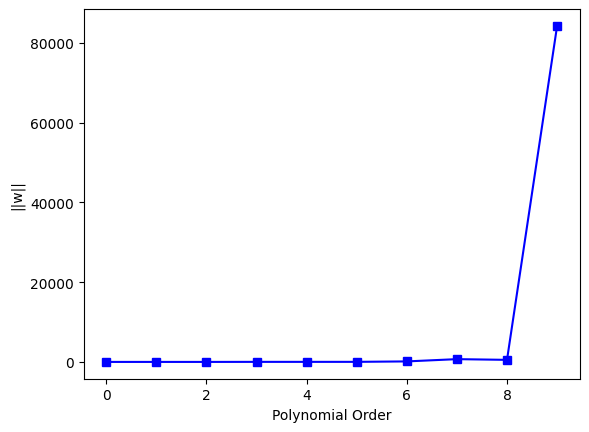

In [ ]:
# Getting magnitude of each weights

w_mag_order=[]

for w_opt in w_opt_order:
  w_mag_order.append(np.abs(w_opt).mean())


plt.plot(w_mag_order, '-s', color='blue')
plt.xlabel('Polynomial Order')
plt.ylabel('||w||')
plt.show()

As you can see, complex functions are associated with high absolute values of their weights. We can thus penalize complexity by adding the following term to the objective function:

$\tilde{J}(\mathbf{w}) = J(\mathbf{w}) + \frac{\lambda}{2} ||\mathbf{w}||^2_2$

where $\lambda$  is the regularization factor (that must be strictly positive) and $||\mathbf{w}||^2_2 = \sum_{j=0}^M w_j^2$.

If we "encourage" the weights to have a smaller norm, we "prioritize" simple functions. This also makes sense according to Occam's Razor: *if many functions can explain your data, choose the simplest one*.

In this case, the gradient is given by:

$\nabla J(\mathbf{w}) = (\mathbf{\Phi}^T\mathbf{\Phi}) \mathbf{w} - \mathbf{\Phi}^T\mathbf{y} + \lambda \mathbf{w}$

If we set $\nabla J(\mathbf{w})=0$, the best weights $\mathbf{w}$ can be computed as:

$\mathbf{w} = (\mathbf{\Phi}^T\mathbf{\Phi} +  \lambda \mathbf{w})^{-1} \mathbf{\Phi}^T\mathbf{y} $

Let's write a function to implement it:

In [ ]:
def get_best_weight_reg(x_train, y_train, order, lambda_reg=1e-04):
  """Compute the optimal solution with the given training set"""

  # Fake initialization (non use to compute the bases)
  weights = np.random.uniform(low=-1.0, high=1.0, size=order+1)
  y_hat, bases = polynomial_model(x_train, weights, order)

  # Computing the optimal solution
  phi_phiT = np.dot(bases.transpose(), bases)
  phi_phiT_reg = phi_phiT + lambda_reg * np.identity(phi_phiT.shape[0])
  phi_phiT_inverse = np.linalg.inv(phi_phiT_reg)
  phi_phiT_inverse_phiT  = np.dot(phi_phiT_inverse, bases.transpose())
  w_opt = np.dot(phi_phiT_inverse_phiT, y_train)

  return w_opt

def evaluate(x,y, w, order):
  """Returns the predictions on the given data samples wit the corresponding
  performance."""
  y_hat, _ = polynomial_model(x, w, order)
  return mse(y, y_hat), y_hat

def optimize_and_evaluate_reg(x_train, y_train, x_test, y_test, order, lambda_reg=1e-04, plot=True):
  """Finds the optimal solution and evaluates its performance."""

  # Compute the optimal solution
  w_opt = get_best_weight_reg(x_train, y_train, order, lambda_reg)

  # Evaluate the performance
  train_loss, train_y_hat = evaluate(x_train, y_train, w_opt, order)
  test_loss, test_y_hat = evaluate(x_test, y_test, w_opt, order)

  # Getting the targeted output (over a lot of points)
  x_data = np.linspace(0, 1, 1000)
  y_data = np.sin(2 * math.pi * x_data)

  # Let's plot predictions vs labels
  if plot:
    plt.plot(x_data , y_data, '-', color='green')
    plt.plot(x_test, test_y_hat, '-', color='red')
    plt.plot(x_train, y_train, 'o', color='blue', fillstyle='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Target Function', 'Learned function', 'Training_data'])
    plt.show()

  return w_opt, train_loss, test_loss


Let's see what happens with different regularization factors:

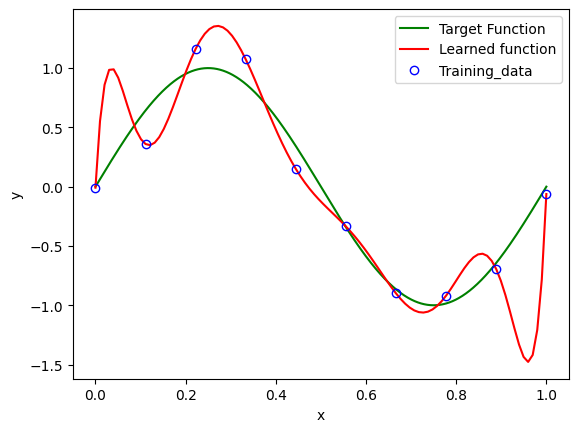

2.003655794774479e-08
0.1320839181866394


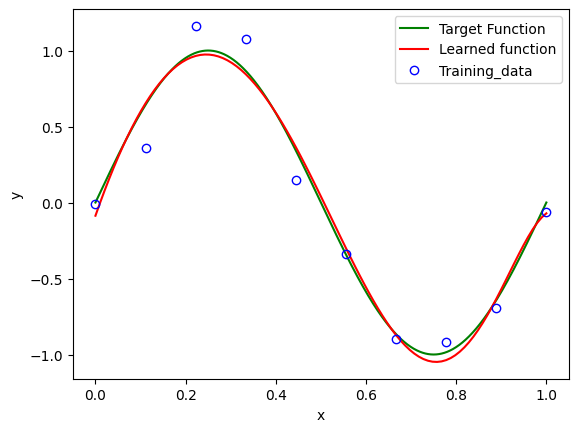

0.025020646465482493
0.0009270590161191773


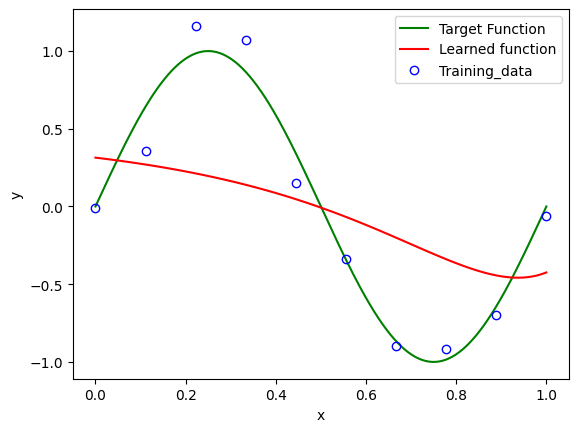

0.298784503374181
0.2635904138033892


In [ ]:
x_train, y_train = get_dataset(10)

order=9

lambda_regs = [0, 1e-04, 1]

for lambda_reg in lambda_regs:
  w_opt, train_loss, test_loss = optimize_and_evaluate_reg(x_train, y_train, x_test, y_test, order, lambda_reg, plot=True)
  print(train_loss)
  print(test_loss)

The hyperparameter $\lambda$ governs the relative importance of the regularization term. It is important to set this value properly to avoid overfitting or underfitting problems. To better assess the impact of this factor, let's monitor the training and test performance with different values of $\lambda$:

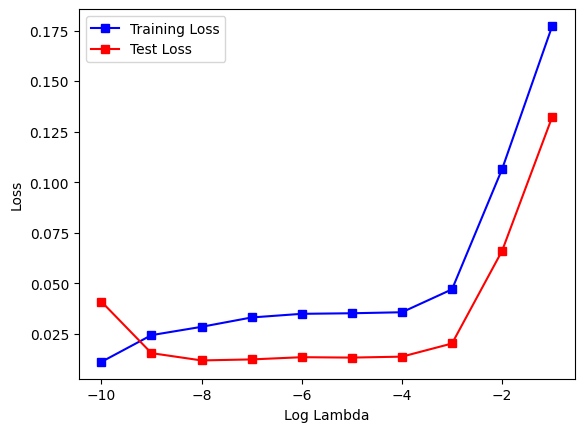

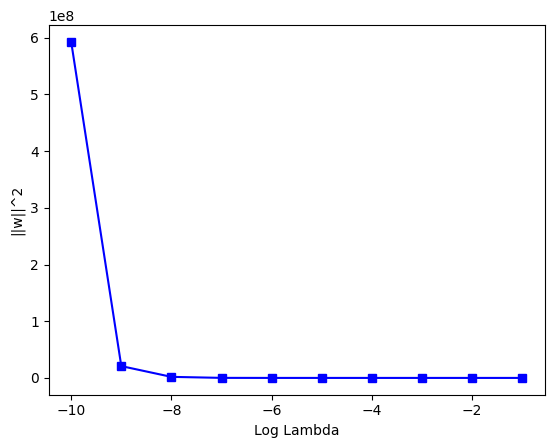

In [ ]:
x_train, y_train = get_dataset(10)

order=9

log_lambda_regs = list(range(-10,0, 1))

w_opt_mag_lambda = []
train_loss_lambda=[]
test_loss_lambda=[]

for log_lambda_reg in log_lambda_regs:
  w_opt, train_loss, test_loss = optimize_and_evaluate_reg(x_train, y_train, x_test, y_test, order, 10**log_lambda_reg, plot=False)
  w_opt_mag_lambda.append((w_opt**2).sum())
  train_loss_lambda.append(train_loss)
  test_loss_lambda.append(test_loss)

plt.plot(log_lambda_regs, train_loss_lambda, '-s', color='blue')
plt.plot(log_lambda_regs, test_loss_lambda, '-s', color='red')
plt.xlabel('Log Lambda')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Test Loss'])
plt.show()


plt.plot(log_lambda_regs, w_opt_mag_lambda, '-s', color='blue')
plt.xlabel('Log Lambda')
plt.ylabel('||w||^2')
plt.show()


The best performance on the test set is normally achieved with $10^{-4}<\lambda<10^{-3}$. Smaller values lead to overfitting, while smaller ones cause underfitting.

# **Curve Fitting with Gradient Descent**
Even though  the optimal solution can be computed for linear models, nothing prevents us to use gradient descend as well.

Let's write a function that computes the gradient and trains the model for a certain number of epochs:

In [ ]:
def training_loop(x_train, y_train, order, N_epochs = 20000, lr = 3.0):
  """Trains the polynomial curve fitting model with gradient descend."""

  # Initial Values
  weights = np.random.uniform(low=-1.0, high=1.0, size=order+1)
  train_loss = []
  test_loss = []
  for epoch in range(N_epochs):

    # compute the predictions
    y_hat, bases = polynomial_model(x_train, weights, order)

    # compute the gradient
    grad = np.dot(bases.T, (y_hat - y_train))

    # Equivalent to
    #phi_phiT = np.dot(bases.T, bases)
    #phi_phiT_w = np.dot(phi_phiT,weights)
    #phiT_y = np.dot(bases.T,y_train)
    #grad = phi_phiT_w - phiT_y

    # Normalization
    grad = grad/(y_hat.shape[0])

    # parameter updates
    weights = weights - lr * grad

  return weights

def evaluate(x,y, w, order):
  """Returns the predictions on the given data samples wit the corresponding
  performance."""
  y_hat, _ = polynomial_model(x, w, order)
  return mse(y, y_hat), y_hat

def optimize_and_evaluate_gd(x_train, y_train, x_test, y_test, order, N_epochs=200, lr=0.1, plot=True):
  """Finds the solution with gradient descend and evaluates its performance."""

  # Compute the optimal solution
  w_gd = training_loop(x_train, y_train, order, N_epochs, lr)

  # Evaluate the performance
  train_loss, train_y_hat = evaluate(x_train, y_train, w_gd, order)
  test_loss, test_y_hat = evaluate(x_test, y_test, w_gd, order)

  # Getting the targeted output (over a lot of points)
  x_data = np.linspace(0, 1, 1000)
  y_data = np.sin(2 * math.pi * x_data)

  # Let's plot predictions vs labels
  if plot:
    plt.plot(x_data , y_data, '-', color='green')
    plt.plot(x_test, test_y_hat, '-', color='red')
    plt.plot(x_train, y_train, 'o', color='blue', fillstyle='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Target Function', 'Learned function', 'Training_data'])
    plt.show()

  return w_gd, train_loss, test_loss


Let's now train the model with different orders of the polynomial:

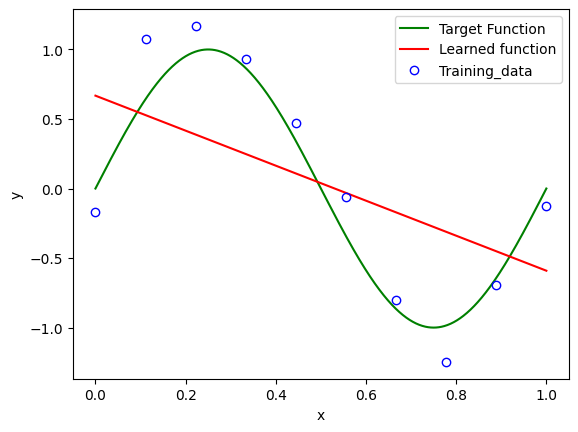

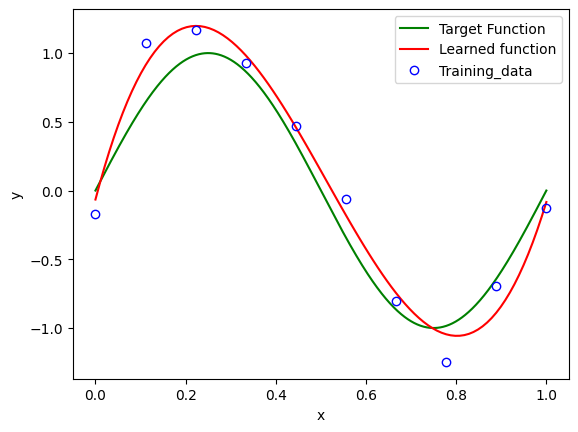

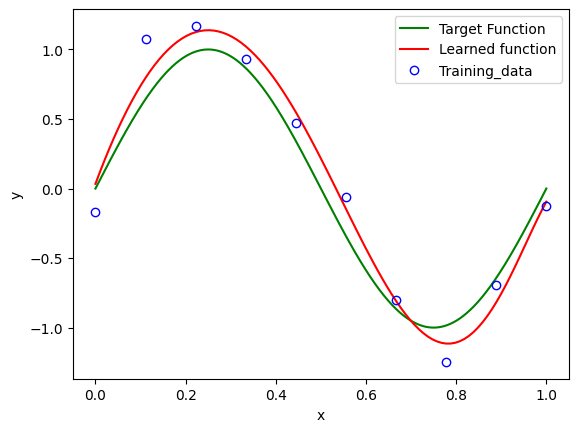

In [ ]:
x_train, y_train = get_dataset(10)

order = 1
weights, train_loss, test_loss = optimize_and_evaluate_gd(x_train, y_train, x_test, y_test, order, N_epochs=200, lr=0.1, plot=True)

order = 3
weights, train_loss, test_loss = optimize_and_evaluate_gd(x_train, y_train, x_test, y_test, order, N_epochs = 20000, lr = 1.0, plot=True)

order = 9
weights, train_loss, test_loss = optimize_and_evaluate_gd(x_train, y_train, x_test, y_test, order, N_epochs = 20000, lr = 0.5, plot=True)

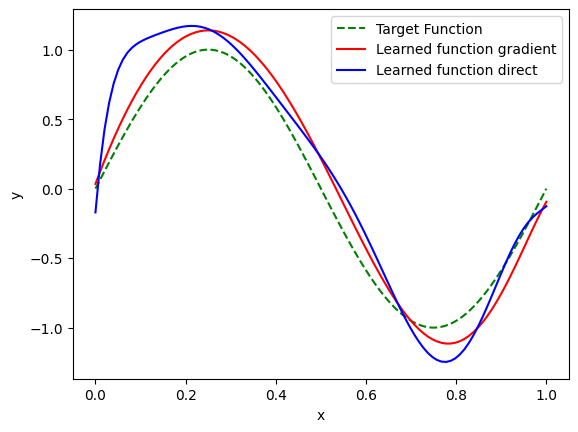

In [ ]:
# Optimal solution
w_opt, train_loss, test_loss = optimize_and_evaluate(x_train, y_train, x_test, y_test, order, plot=False)

# compare gradient descend with direct
test_y_hat_gradient, _ = polynomial_model(x_test, weights, order)
test_y_hat_direct, _ = polynomial_model(x_test, w_opt, order)

# Getting the targeted output (over a lot of points)
x_data = np.linspace(0, 1, 1000)
y_data = np.sin(2 * math.pi * x_data)


plt.plot(x_data , y_data, '--', color='green')
plt.plot(x_test, test_y_hat_gradient, '-', color='red')
plt.plot(x_test, test_y_hat_direct, '-', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Target Function', 'Learned function gradient', 'Learned function direct'])
plt.show()



As you can see, the direct solution without regularization tens to overfit more than the solution found by gradient descent.  

*Why?*

Converging to the optimal solution (according to the training data) indeed increases the risk of overfitting when little data is used. Gradient descent, especially when trained with a fixed learning rate, cannot easily reach the exact solution. This might sound like a bad thing, but it ends up helping against overfitting.

# **Conclusion**
We have seen an example of polynomial curve fitting. Despite being a simple example, it has been useful to introduce crucial concepts of machine learning such as underfitting, overfitting, capacity, and regularization.